In [4]:
import h5py
import mediapy
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
path='recording.hdf5'
f = h5py.File(path,'r')

In [8]:
#images = [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in f['images']]

#mediapy.show_video(images, fps=30)

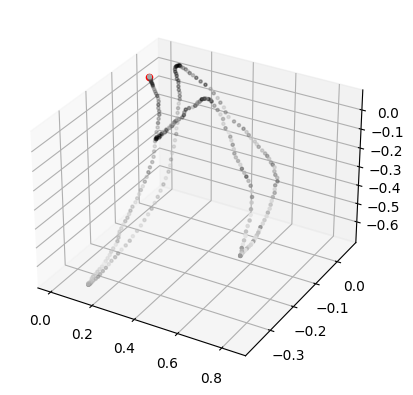

In [7]:
poses = np.array(f['poses'])
pose_confidences = f['poses'].attrs['pose_confidences']

cam_pos =  poses[:,:3,3]

color = [str(i/100) for i in pose_confidences]

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(*cam_pos[0,:3], c='red', marker='o')
ax.scatter(cam_pos[:,0], cam_pos[:,1], cam_pos[:,2], c=color, marker='.')

plt.show()
